# PC-Lab: Calibration of Machine Learning Models


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.datasets import fetch_openml
from sklearn.calibration import calibration_curve
from sklearn.naive_bayes import GaussianNB

from torchvision import datasets, transforms

## Introduction to Calibration in Machine Learning

In machine learning, uncertainty estimation is crucial for understanding the confidence level of model predictions.
 It involves quantifying the degree of certainty or doubt associated with a model's predictions. 

## What is Calibration?

Calibration in machine learning refers to the process of aligning a model's predicted probabilities with the actual outcomes.
 A well-calibrated model provides probability estimates that match the true likelihood of an event occurring. 
 For example, if a calibrated model predicts an event with 70% probability, 
then approximately 70% of the predictions at this probability level should be correct.

### The Importance of Calibration

Calibration is essential for two main reasons:

- **Trustworthiness**: A calibrated model ensures _trustworthiness_ in its predictions, which is vital for decision-making processes.
- **Decision-making**: In some applications, decisions are made based on the predicted probabilities rather than the classification itself. Accurate probability estimates are, therefore, crucial.

### Assesing Model Calibration

1. **Calibration Curve** <src img >
2. Analytical Scores

## 1. Binary dataset

In the first task, we will look at the simple case of binary classification, and compare the calibration of different classifier models
using calibration curves and 

In [35]:
from sklearn.datasets import make_blobs

dataset_binary = make_blobs(n_samples=10000, centers=5, n_features=2, random_state=42)

dataset_binary[1][:] = dataset_binary[1] > 2


Visualise the dataset in a scatterplot:

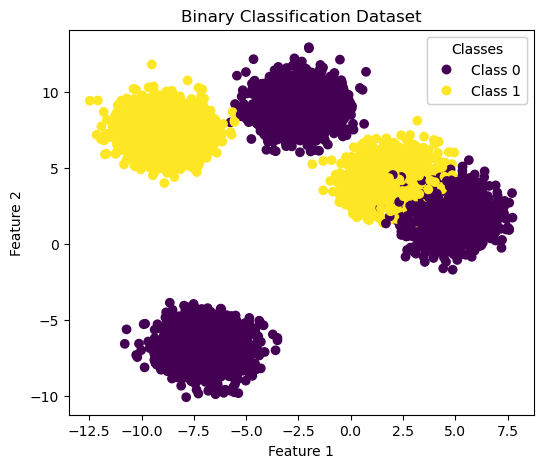

In [36]:
x, y = dataset_binary

fig, ax = plt.subplots(figsize=(6, 5))
scatter = ax.scatter(x[:, 0], x[:, 1], c=y, cmap='viridis')
handles, labels = scatter.legend_elements()
labels = ['Class 0', 'Class 1']

legend = ax.legend(handles, labels, loc="upper right", title="Classes")
ax.add_artist(legend)
plt.title('Binary Classification Dataset')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
plt.show()



now train a classifier on the data.

In [38]:
# train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5, random_state=42)

clf = GaussianNB()
clf.fit(x_train, y_train)

GaussianNB()

Let's look at the probabilities our classifier outputs in different regions of the feature space:

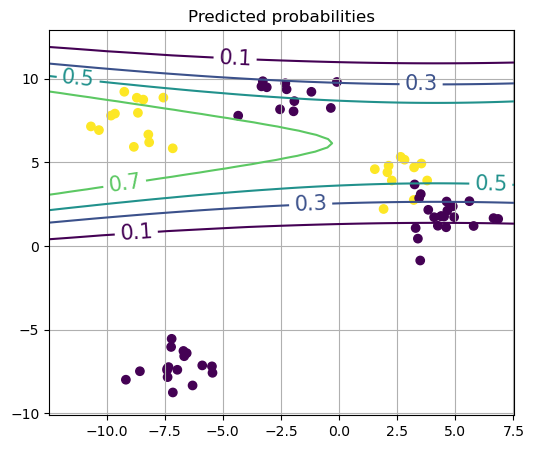

In [40]:
delta = 0.25
x0_grid = np.arange(x[:, 0].min(), x[:, 0].max(), delta)
x1_grid = np.arange(x[:, 1].min(), x[:, 1].max(), delta)
X0, X1 = np.meshgrid(x0_grid, x1_grid)
Y = clf.predict_proba(np.vstack((X0.flatten(), X1.flatten())).T)

fig, ax = plt.subplots(figsize=(6, 5))
CS = ax.contour(X0, X1, Y[:, 1].reshape(X0.shape), levels=[.1, .3, .5, .7, .9])
ax.clabel(CS, inline=1, fontsize=15)
ax.scatter(x_test[:75, 0], x_test[:75, 1], c=y_test[:75])
ax.set_title('Predicted probabilities')
ax.grid()

We can also look at the positive scores the classifier gives to each sample. 

Text(0, 0.5, 'Predicted probability')

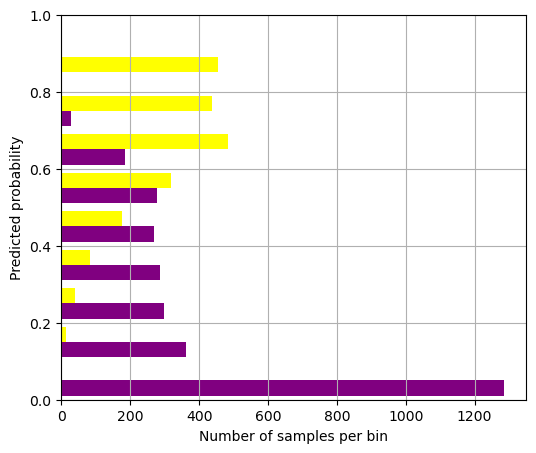

In [46]:
# divide the scores into bins
n_bins = 10
bins = np.linspace(0, 1, n_bins + 1)

# predictions on test set
p_pred = clf.predict_proba(x_test)

fig, ax = plt.subplots(figsize=(6, 5))

ax.hist([p_pred[y_test == 0, 1], p_pred[y_test == 1, 1]], bins=bins, orientation='horizontal', label=['Class 0', 'Class 1'],
        color=["purple", "yellow"])
ax.set_ylim(0, 1)
ax.grid()
ax.set_xlabel('Number of samples per bin')
ax.set_ylabel('Predicted probability')

We see that the model gives lower scores to the first class, and that most of the instances of that class
are in the range of scores between $0$ and $0.1$. The last bin between $0.9$ and $1.0$ does not contain any sample. 

In order to now plot the reliability diagram, we need to sompute the mean scores in each bin., as well as the true proportion
of positives. Use the function ```np.digitize``` to return the index of the corresponding bin for each instance.

In [47]:
# assign each of the instances to a bin
bin_index = np.digitize(p_pred[:, 1], bins=bins)
print(bin_index)

[1 1 7 ... 9 1 6]


Now compute the mean score in each bin:


In [48]:
pred_means = [p_pred[:, 1][bin_index == i].mean() for i in range(1, n_bins + 1)]
print(pred_means)

[0.01243248705250189, 0.15203439630231705, 0.24868816147980208, 0.3514564346996097, 0.4502977408011178, 0.553454738379453, 0.6486686394892507, 0.7595789271035308, 0.8238768795804186, nan]


/var/folders/mf/gnm849bj4fq5xnqhl_bdhf9m0000gn/T/ipykernel_29974/2406672727.py:1: RuntimeWarning: Mean of empty slice.
  pred_means = [p_pred[:, 1][bin_index == i].mean() for i in range(1, n_bins + 1)]
/Users/mirajuergens/opt/miniconda3/envs/mlfls/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [49]:
y_means = [y_test[bin_index == i].mean() for i in range(1, n_bins+1)]

/var/folders/mf/gnm849bj4fq5xnqhl_bdhf9m0000gn/T/ipykernel_29974/3389586688.py:1: RuntimeWarning: Mean of empty slice.
  y_means = [y_test[bin_index == i].mean() for i in range(1, n_bins+1)]
/Users/mirajuergens/opt/miniconda3/envs/mlfls/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Now we can plot a line with the mean scores in the $x$ axis and the true positive rate on the $y$ axis.

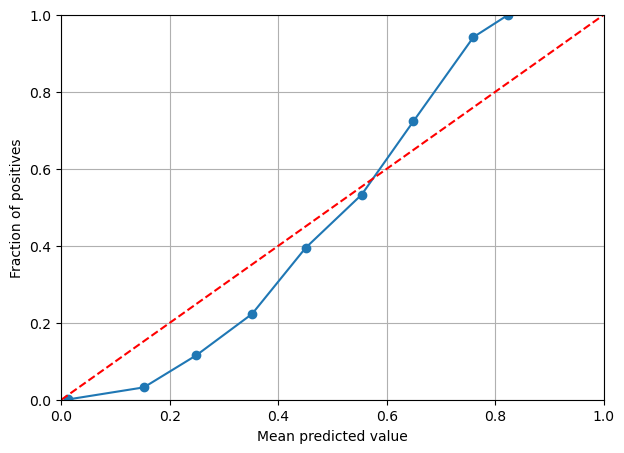

In [52]:
fig, ax = plt.subplots( figsize=(7, 5))
ax.plot(pred_means, y_means, 'o-')
ax.plot([0, 1], [0, 1], 'r--')
ax.set_xlim(0, 1)
ax.set_xlabel('Mean predicted value')
ax.set_ylim(0, 1)
ax.set_ylabel('Fraction of positives')
ax.grid()

#### Datasets
As a simple demo dataset, we'll use MNIST - one of the most popular comp

In [7]:
train_data = datasets.MNIST(
    root = 'data',
    train = True,
    transform = transforms.ToTensor(),
    download = True,
)
test_data = datasets.MNIST(
    root = 'data',
    train = False,
    transform = transforms.ToTensor()
)

X_train = train_data.data
y_train = train_data.targets

X_test = test_data.data
y_test = test_data.targets

X_train = X_train / 255
X_test = X_test / 255

100%|██████████| 9912422/9912422 [00:04<00:00, 2078171.77it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 3309718.41it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 2274498.90it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5078786.66it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



To simplify things, we will convert the problem into a binary classification problem by distinguishing only between even and odd numbers.

In [11]:
# convert into binary problem: all even numbers are 0, all odd numbers are 1
y_train = y_train % 2
y_test = y_test % 2

X_train = X_train.reshape(-1, 28*28)
X_test = X_test.reshape(-1, 28*28)



In [12]:
y_train

tensor([1, 0, 0,  ..., 1, 0, 0])

### Calibrating Models

1. **Isotonic Regression**
2. **Platt Scaling**